# Übung: Alarmmanagement – Datenanalyse und Alarmflutklassifikation

In dieser Übung durchlaufen Sie eine vollständige Pipeline des industriellen Alarmmanagements. Ziel ist es, die grundlegenden Konzepte praktisch umzusetzen, von der Verarbeitung realer Prozessdaten über die Berechnung von Alarmmetriken bis hin zur Implementierung und Auswertung von Methoden zur Klassifikation von Alarmfluten.

**Lernziele:**
- Umgang mit industriellen Alarmdaten
- Berechnung relevanter Alarmmetriken
- Implementierung einfacher Techniken (z.B. Alarm-Totbänder)
- Extraktion von Merkmalen zur Klassifikation von Alarmfluten (WDI-1NN & ACM-SVM)
- Evaluation der Klassifikationsergebnisse (Confusion Matrix, Genauigkeit)

Die jeweiligen Stellen zur eigenständigen Implementierung sind im Notebook mit **"TODO"** klar gekennzeichnet.

In [ ]:
import numpy as np
import pandas as pd

## 1. Datensatz laden und erkunden

Laden Sie den bereitgestellten Datensatz mit vorannotierten Alarmfluten. Erkunden Sie anschließend die Struktur der Daten.

- Prozessvariablen und Alarmfluten sind bereits enthalten.
- Gelabelte Klassen (Klassen 0 bis 4) liegen ebenfalls vor (z.B. Ursachen für Alarmfluten).

In [33]:
# Leere Listen für Daten und Labels initialisieren
data = []
labels = []

for j in range(1, 1001):
    # Pfad zur CSV-Datei
    csv_file_path = 'process_data/sample_{}.csv'.format(j)
    # Lese die Daten aus der CSV-Datei
    df = pd.read_csv(csv_file_path, index_col=None)
    df = df.drop(df.columns[0], axis=1)
    if j in range(1, 201):
        l = 0
    elif j in range(201, 401):
        l = 1
    elif j in range(401, 601):
        l = 2
    elif j in range(601, 801):
        l = 3
    elif j in range(801, 1001):
        l = 4
        # continue
    labels.append(l)
    data.append(df.values.transpose())

# Konvertiere Daten und Labels in numpy-Arrays
X = np.array(data)
y = np.array(labels)

# Gib die Form der Daten und Labels aus
print("Datenform: {}".format(X.shape))
print("Labels-Form: {}".format(y.shape))
unique, counts = np.unique(y, return_counts=True)
print("Klassenverteilung:")
for cls, cnt in zip(unique, counts):
    print(f"Klasse {cls}: {cnt}")

Datenform: (1000, 10, 300)
Labels-Form: (1000,)
Klassenverteilung:
Klasse 0: 200
Klasse 1: 200
Klasse 2: 200
Klasse 3: 200
Klasse 4: 200


## 2. Alarmdaten aus Prozessdaten generieren

Erzeugen Sie aus den Prozessdaten binäre Alarmdaten. Die Alarmgrenzwerte sind vorgegeben.

- Ein Alarm wird aktiv, wenn der Grenzwert überschritten wird (HI-Alarm) oder unterschritten wird (LO-Alarm).

In [ ]:
# TODO: Alarmdaten aus Prozessvariablen generieren

In [34]:
# Vorgegebene Grenzwerte für 22 Alarmvariablen
# 11x HI (oberer Grenzwert), 11x LO (unterer Grenzwert)
alarm_limits_lo = np.array([-0.08, 31.50, 122.88, 0.09, 90.85, 2697.26, 44.02, 265.73, 102.19, 39.55, 28.94])
alarm_limits_hi = np.array([0.62, 33.34, 122.92, 0.33, 93.19, 2711.82, 55.98, 280.31, 102.75, 40.45, 38.32])

num_samples, num_variables, num_timesteps = X.shape

# Binäre Alarmdaten initialisieren
X_alarms = np.zeros((num_samples, num_variables * 2, num_timesteps))

# Alarme generieren
for sample_idx in range(num_samples):
    for var_idx in range(num_variables):
        hi_limit = alarm_limits_hi[var_idx]
        lo_limit = alarm_limits_lo[var_idx]

        # High-Alarm aktiv, wenn Wert > HI-Limit
        X_alarms[sample_idx, var_idx, :] = (X[sample_idx, var_idx, :] > hi_limit).astype(int)

        # Low-Alarm aktiv, wenn Wert < LO-Limit
        X_alarms[sample_idx, var_idx + num_variables, :] = (X[sample_idx, var_idx, :] < lo_limit).astype(int)

# Ausgabe zur Kontrolle
print("Shape der generierten Alarmdaten:", X_alarms.shape)
print("Beispiel für generierte Alarmdaten (erstes Sample):")
print(X_alarms[0])

Shape der generierten Alarmdaten: (1000, 20, 300)
Beispiel für generierte Alarmdaten (erstes Sample):
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 0. 0.]]


## 3. Berechnung relevanter Alarmmetriken

Berechnen Sie folgende Metriken:

- Maximale und durchschnittliche Anzahl aktiver Alarme pro 10 Zeitschritte über alle Alarmfluten
- Maximale und durchschnittliche Anzahl neu aktivierter Alarme pro 10 Zeitschritte über alle Alarmfluten

In [ ]:
# TODO: Alarmmetriken berechnen und visualisieren

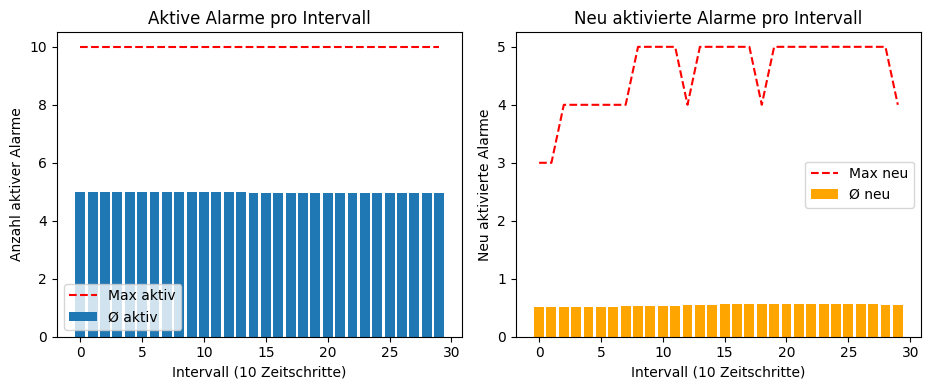

In [35]:
import matplotlib.pyplot as plt

# Anzahl Zeitschritte pro Intervall
interval = 10
num_intervals = num_timesteps // interval

# 1. Durchschnittliche Anzahl aktiver Alarme pro Intervall
active_alarms_per_interval = []
max_active_alarms_per_interval = []
for i in range(num_intervals):
    start = i * interval
    end = (i + 1) * interval
    # Summe der aktiven Alarme pro Sample und Intervall
    active = X_alarms[:, :, start:end].sum(axis=2)
    # Mittelwert über alle Samples und Alarmvariablen
    mean_active = active.mean()
    active_alarms_per_interval.append(mean_active)
    # Maximale Anzahl aktiver Alarme in diesem Intervall (über alle Samples)
    max_active = active.max()
    max_active_alarms_per_interval.append(max_active)

# 2. Durchschnittliche Anzahl neu aktivierter Alarme pro Intervall
new_alarms_per_interval = []
max_new_alarms_per_interval = []
for i in range(num_intervals):
    start = i * interval
    end = (i + 1) * interval
    diff = np.diff(X_alarms[:, :, start:end], axis=2, prepend=0)
    new_alarms = (diff == 1).sum(axis=2)
    mean_new = new_alarms.mean()
    new_alarms_per_interval.append(mean_new)
    max_new = new_alarms.max()
    max_new_alarms_per_interval.append(max_new)

# Visualisierung
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.bar(range(num_intervals), active_alarms_per_interval, label='Ø aktiv')
plt.plot(range(num_intervals), max_active_alarms_per_interval, 'r--', label='Max aktiv')
plt.xlabel('Intervall (10 Zeitschritte)')
plt.ylabel('Anzahl aktiver Alarme')
plt.title('Aktive Alarme pro Intervall')
plt.legend()

plt.subplot(1, 3, 2)
plt.bar(range(num_intervals), new_alarms_per_interval, color='orange', label='Ø neu')
plt.plot(range(num_intervals), max_new_alarms_per_interval, 'r--', label='Max neu')
plt.xlabel('Intervall (10 Zeitschritte)')
plt.ylabel('Neu aktivierte Alarme')
plt.title('Neu aktivierte Alarme pro Intervall')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Implementierung eines Alarm-Totbands

Implementieren Sie ein Totband für Alarme, um das häufige Aktivieren und Deaktivieren (Flattern) zu vermeiden.

- Berechnen Sie das Totband basierend auf gegebenen Prozentwerten.

In [ ]:
# TODO: Alarm-Totband implementieren und erneut Alarme generieren und erneut Metriken berechnen sowie visualisieren

In [36]:
# Prozentwert des Totbands (z.B. 1% als Beispiel)
deadband_percentage = 0.20

# Berechnung der Mittelwerte zwischen HI und LO Grenzwerten
alarm_mid_values = (alarm_limits_hi + alarm_limits_lo) / 2
alarm_ranges = np.abs(alarm_limits_hi - alarm_limits_lo)

# Berechnung des Totbands pro Prozessvariable
alarm_deadbands = (alarm_ranges / 2) * deadband_percentage

# Anpassen der Grenzwerte mit Totband
adjusted_hi_limits = alarm_limits_hi - alarm_deadbands
adjusted_lo_limits = alarm_limits_lo + alarm_deadbands

# Binäre Alarmdaten mit Totband initialisieren
X_alarms_deadband = np.zeros((num_samples, num_variables * 2, num_timesteps))

# Alarme mit Totband generieren
for sample_idx in range(num_samples):
    for var_idx in range(num_variables):
        hi_limit_adj = adjusted_hi_limits[var_idx]
        lo_limit_adj = adjusted_lo_limits[var_idx]

        # High-Alarm mit angepasstem Totband
        X_alarms_deadband[sample_idx, var_idx, :] = (
            X[sample_idx, var_idx, :] > hi_limit_adj
        ).astype(int)

        # Low-Alarm mit angepasstem Totband
        X_alarms_deadband[sample_idx, var_idx + num_variables, :] = (
            X[sample_idx, var_idx, :] < lo_limit_adj
        ).astype(int)

# Ausgabe zur Kontrolle
print("Shape der Alarmdaten mit Totband:", X_alarms_deadband.shape)
print("Beispiel für Alarmdaten mit Totband (erstes Sample):")
print(X_alarms_deadband[0])


Shape der Alarmdaten mit Totband: (1000, 20, 300)
Beispiel für Alarmdaten mit Totband (erstes Sample):
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 0. 0.]]


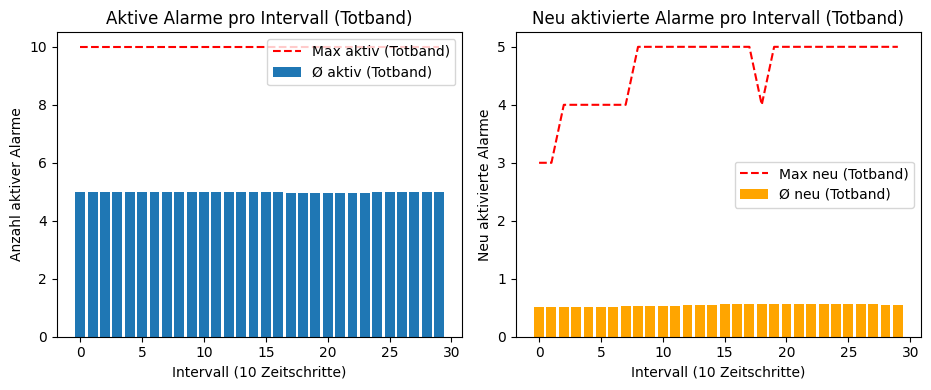

In [37]:
import matplotlib.pyplot as plt

# Anzahl Zeitschritte pro Intervall
interval = 10
num_intervals = num_timesteps // interval

# 1. Durchschnittliche Anzahl aktiver Alarme pro Intervall (Totband)
active_alarms_per_interval = []
max_active_alarms_per_interval = []
for i in range(num_intervals):
    start = i * interval
    end = (i + 1) * interval
    active = X_alarms_deadband[:, :, start:end].sum(axis=2)
    mean_active = active.mean()
    active_alarms_per_interval.append(mean_active)
    max_active = active.max()
    max_active_alarms_per_interval.append(max_active)

# 2. Durchschnittliche Anzahl neu aktivierter Alarme pro Intervall (Totband)
new_alarms_per_interval = []
max_new_alarms_per_interval = []
for i in range(num_intervals):
    start = i * interval
    end = (i + 1) * interval
    diff = np.diff(X_alarms_deadband[:, :, start:end], axis=2, prepend=0)
    new_alarms = (diff == 1).sum(axis=2)
    mean_new = new_alarms.mean()
    new_alarms_per_interval.append(mean_new)
    max_new = new_alarms.max()
    max_new_alarms_per_interval.append(max_new)

# Visualisierung
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.bar(range(num_intervals), active_alarms_per_interval, label='Ø aktiv (Totband)')
plt.plot(range(num_intervals), max_active_alarms_per_interval, 'r--', label='Max aktiv (Totband)')
plt.xlabel('Intervall (10 Zeitschritte)')
plt.ylabel('Anzahl aktiver Alarme')
plt.title('Aktive Alarme pro Intervall (Totband)')
plt.legend()

plt.subplot(1, 3, 2)
plt.bar(range(num_intervals), new_alarms_per_interval, color='orange', label='Ø neu (Totband)')
plt.plot(range(num_intervals), max_new_alarms_per_interval, 'r--', label='Max neu (Totband)')
plt.xlabel('Intervall (10 Zeitschritte)')
plt.ylabel('Neu aktivierte Alarme')
plt.title('Neu aktivierte Alarme pro Intervall (Totband)')
plt.legend()

plt.tight_layout()
plt.show()


## 5. Alarmflutklassifikation

Klassifizieren Sie Alarmfluten mit zwei unterschiedlichen Methoden:

1. **WDI-1NN**: Gewichteter Dissimilaritätsindex mit Nearest Neighbor Klassifikation
2. **ACM-SVM**: Alarm-Coaktivierungsmatrix mit Support Vector Machine Klassifikation

Implementieren Sie dafür ausschließlich die Merkmalsextraktion.  
Die Klassifikationslogik (SVM, 1NN) ist bereits vorgegeben.

In [6]:
# TODO: Daten in Trainings- und Testset aufteilen

In [38]:
from sklearn.model_selection import train_test_split

# Aufteilen der Alarmdaten mit Totband (X_alarms_deadband) und Labels (y) in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(
    X_alarms_deadband, y, test_size=0.2, random_state=42, stratify=y
)

print("Trainingsdaten Shape:", X_train.shape)
print("Testdaten Shape:", X_test.shape)
print("Trainingslabels Shape:", y_train.shape)
print("Testlabels Shape:", y_test.shape)

Trainingsdaten Shape: (800, 20, 300)
Testdaten Shape: (200, 20, 300)
Trainingslabels Shape: (800,)
Testlabels Shape: (200,)


### 5.1 WDI-1NN: Feature-Extraktion (Templates und Gewichte)

Implementieren Sie die Berechnung der gewichteten Templates (WDI-Feature-Extraktion).

In [ ]:
# TODO: WDI-Templates und Gewichte aus Trainingsdaten berechnen

In [40]:
import numpy as np
import pandas as pd


class WDI_1NN:
    def __init__(self, params={"template_threshold": 0.5}):
        self.classes = None
        self.templates = None
        self.weights_novelty = None
        self.weights_assignment = None
        self.X_active = None
        self.template_threshold = params["template_threshold"]

    @property
    def __name__(self):
        return "WDI_1NN"

    def fit(self, X, y):
        self.calc_templates(X, y)
        self.calc_weights()

    def predict_proba(self, X):
        # get vectors with active alarms per sample
        X_active = np.array(self.calc_active_alarms(X))
        y_proba = []
        # iterate over samples
        for i in range(X_active.shape[0]):
            y_assign_i = []
            # iterate over classes
            for c in self.classes:
                # calculate dissimilarity for assignment
                if sum(self.weights_assignment[c]) != 0.0:
                    y_assign_i.append(
                        sum(
                            self.weights_assignment[c]
                            * np.abs(X_active[i] - self.templates[c][1])
                        )
                        / sum(self.weights_assignment[c])
                    )
                else:
                    y_assign_i.append(0)
            # get class dissimilarities
            y_proba.append(y_assign_i)
        return np.array(y_proba)

    def calc_active_alarms(self, X):
        X_active = []
        for i in range(X.shape[0]):
            # transform in DataFrame
            df = pd.DataFrame(X[i].transpose())
            df_max = df.max()
            X_active.append([1 if df_max[j] == 1 else 0 for j in range(X.shape[1])])
        return np.array(X_active)

    def calc_templates(self, X, y):
        # get set of unique class labels in y
        self.classes = np.unique(y)
        # get vectors with active alarms per sample
        self.X_active = self.calc_active_alarms(X)
        # get the templates per class
        templates = {}
        for c in self.classes:
            sample_indices = np.where(y == c)
            class_frequency = sum(self.X_active[sample_indices]) / len(
                sample_indices[0]
            )
            class_template = np.where(class_frequency > self.template_threshold, 1, 0)
            templates[c] = [class_frequency, class_template]
        self.templates = templates

    def calc_weights(self):
        weights_assignment, weights_novelty, alpha_weights, beta_weights = (
            {},
            {},
            {},
            {},
        )
        # iterate over all templates / classes
        for c in self.classes:
            # calc alpha weights
            alpha_weights[c] = (self.templates[c][0] * self.templates[c][1]) + (
                (1 - self.templates[c][0]) * np.where(self.templates[c][1] == 1, 0, 1)
            )
        for c in self.classes:
            # calc beta weights
            beta_weights[c] = (sum(alpha_weights.values()) - alpha_weights[c]) / (
                self.classes.shape[0] - 1
            )
            # calc full weights
            weights_novelty[c] = 2 * alpha_weights[c] - 1
            # weights_novelty[c] = np.where(
            #     weights_novelty[c] >= 0, weights_novelty[c], 0
            # )
            weights_assignment[c] = (2 * alpha_weights[c] - 1) * (1 - beta_weights[c])
            # weights_assignment[c] = np.where(
            #     weights_assignment[c] >= 0, weights_assignment[c], 0
            # )
        self.weights_assignment = weights_assignment
        self.weights_novelty = weights_novelty


### 5.2 ACM-SVM: Feature-Extraktion (Alarm-Koaktivierungsmatrix)

Implementieren Sie die Erstellung der Alarm-Koaktivierungsmatrix (ACM).

In [ ]:
# TODO: ACM aus Trainingsdaten berechnen

In [41]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


class ACM_SVM:
    """
    Alarm Coactivation Matrix Support Vector Machine classifier
    """

    def __init__(self, params={}):
        self.clf = None

    @property
    def __name__(self):
        return "ACM_SVM"

    def fit(self, X, y):
        # get alarm coactivations
        X_acm = self.calc_coactivation(X)
        # train SVM with one-vs-one scheme
        self.clf = make_pipeline(StandardScaler(), SVC(probability=True))
        self.clf.fit(X_acm, y)

    def predict_proba(self, X):
        # get alarm coactivations
        X_acm = self.calc_coactivation(X)
        # get the posterior class probabilities
        y_scores = self.clf.predict_proba(X_acm)
        return np.array(y_scores)

    # def calc_coactivation(self, X):
    #     acm = []
    #     # iterate over all DataFrames
    #     for i in range(X.shape[0]):
    #         acm_i = []
    #         # transform in DataFrame
    #         df = pd.DataFrame(X[i].transpose())
    #         df_sum = df.sum()
    #         # iterate over all signal pairs
    #         for j in range(X.shape[1]):
    #             for k in range(j, X.shape[1]):
    #                 # calculate coactivity for each pair
    #                 if df_sum[j] == 0 or df_sum[k] == 0:
    #                     acm_i.append(0)
    #                 elif j == k:
    #                     acm_i.append(1)
    #                 else:
    #                     df_pair = df[j] + df[k]
    #                     a = df_pair[df_pair == 2].count()
    #                     b_c = df_pair[df_pair == 1].count()
    #                     # calculate Jaccard similarity for each pair
    #                     if a == 0 and b_c == 0:
    #                         acm_i.append(0)
    #                     else:
    #                         acm_i.append((a / (a + b_c)))
    #         acm.append(acm_i)
    #     # create np.array over all samples with
    #     # shape (n_samples, n_signal_pairs)
    #     return np.array(acm)

    def calc_coactivation(self, X):
        """
        Compute the coactivation matrix for each sample in the 3D numpy array X.
        Each coactivation matrix contains Jaccard scores for each pair of variables.

        :param X: 3D numpy array of shape (n_samples, n_variables, n_timesteps)
        :return: 2D numpy array of shape (n_samples, n_variables*(n_variables-1)/2)
        """
        n_samples, n_variables, _ = X.shape
        # Initialize the result array with zeros
        result = np.zeros((n_samples, n_variables * (n_variables - 1) // 2))

        # Iterate over each sample
        for i in range(n_samples):
            # Initialize a list to store the Jaccard scores for this sample
            jaccard_scores = []

            # Iterate over each pair of variables
            for v1 in range(n_variables):
                for v2 in range(v1 + 1, n_variables):
                    # Compute the intersection and union of activations for the pair
                    intersection = np.sum((X[i, v1, :] == 1) & (X[i, v2, :] == 1))
                    union = np.sum((X[i, v1, :] == 1) | (X[i, v2, :] == 1))

                    # Calculate the Jaccard score
                    if union == 0:
                        jaccard_score = 0
                    else:
                        jaccard_score = intersection / union

                    # Add the Jaccard score to the list
                    jaccard_scores.append(jaccard_score)

            # Store the Jaccard scores in the result array
            result[i, :] = jaccard_scores

        return result


### 5.3 Training der Klassifikationsmodelle (Vorgegeben)

Dieser Schritt ist bereits implementiert. Hier werden die extrahierten Merkmale für das Training verwendet.

In [ ]:
# Dieser Teil ist bereits implementiert (zur Verfügung gestellt)

In [42]:
# WDI-1NN Modell trainieren
wdi_model = WDI_1NN(params={"template_threshold": 0.5})
wdi_model.fit(X_train, y_train)

# ACM-SVM Modell trainieren
acm_model = ACM_SVM()
acm_model.fit(X_train, y_train)

## 6. Evaluierung der Klassifikation

Evaluieren Sie nun Ihre beiden Klassifikationsmodelle auf dem Testset:

- Berechnung und Ausgabe der Genauigkeit (Accuracy)
- Erzeugung einer Confusion Matrix zur Ergebnisbewertung

In [ ]:
# TODO: Ergebnisse evaluieren und Confusion Matrix erzeugen

WDI-1NN Accuracy: 0.395


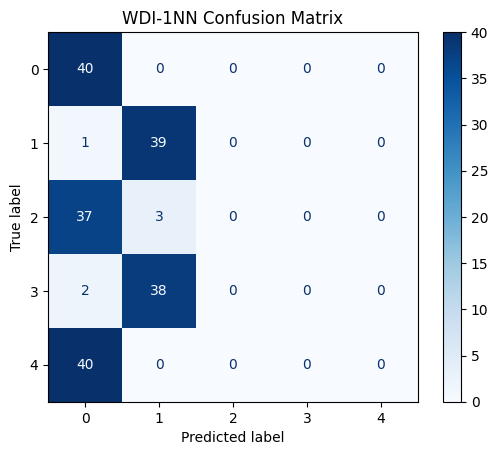

ACM-SVM Accuracy: 0.720


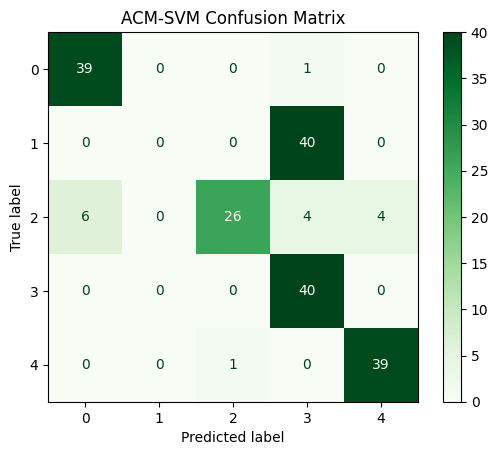

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt

# WDI-1NN Vorhersagen
wdi_probs = wdi_model.predict_proba(X_test)
wdi_preds = np.argmin(wdi_probs, axis=1)
wdi_acc = accuracy_score(y_test, wdi_preds)
wdi_cm = confusion_matrix(y_test, wdi_preds)

print(f"WDI-1NN Accuracy: {wdi_acc:.3f}")
disp1 = ConfusionMatrixDisplay(wdi_cm)
disp1.plot(cmap="Blues")
plt.title("WDI-1NN Confusion Matrix")
plt.show()

# ACM-SVM Vorhersagen
acm_probs = acm_model.predict_proba(X_test)
acm_preds = np.argmax(acm_probs, axis=1)
acm_acc = accuracy_score(y_test, acm_preds)
acm_cm = confusion_matrix(y_test, acm_preds)

print(f"ACM-SVM Accuracy: {acm_acc:.3f}")
disp2 = ConfusionMatrixDisplay(acm_cm)
disp2.plot(cmap="Greens")
plt.title("ACM-SVM Confusion Matrix")
plt.show()

## 7. Zusammenfassung und Interpretation

- Vergleichen Sie die Ergebnisse der beiden Methoden.
- Diskutieren Sie die erzielte Genauigkeit und eventuelle Stärken und Schwächen der Methoden.